In [1]:
import pandas as pd
import numpy as np
import re
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.feature_selection import SelectFromModel, SelectKBest
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

sns.set(style='white', context='notebook', palette='deep')
pd.options.display.max_columns = 100

In [2]:
train = pd.read_csv("cs-trainings.csv")
kaggle_test = pd.read_csv("cs-tests.csv")

In [3]:
train.shape

(150042, 12)

In [4]:
train.describe()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,117655.000000,117655.000000,117655.000000,117655.000000,117655.000000,117655.000000,9.445600e+04,117655.000000,117655.000000,117655.000000,117655.000000,114609.000000
mean,90348.258170,0.066865,6.082753,52.288887,0.416370,352.126795,6.686398e+03,8.462743,0.259334,1.017492,0.234618,0.756415
std,35694.900634,0.249789,245.864119,14.770970,4.124611,2147.183477,1.581980e+04,5.151861,4.100198,1.128335,4.085833,1.113494
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,61759.500000,0.000000,0.029846,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,91173.000000,0.000000,0.153446,52.000000,0.000000,0.365849,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,120586.500000,0.000000,0.557748,63.000000,0.000000,0.865502,8.240000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,150000.000000,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,57.000000,98.000000,32.000000,98.000000,13.000000


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150042 entries, 0 to 150041
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            117655 non-null  float64
 1   SeriousDlqin2yrs                      117655 non-null  float64
 2   RevolvingUtilizationOfUnsecuredLines  117655 non-null  float64
 3   age                                   117655 non-null  float64
 4   NumberOfTime30-59DaysPastDueNotWorse  117655 non-null  float64
 5   DebtRatio                             117655 non-null  float64
 6   MonthlyIncome                         94456 non-null   float64
 7   NumberOfOpenCreditLinesAndLoans       117655 non-null  float64
 8   NumberOfTimes90DaysLate               117655 non-null  float64
 9   NumberRealEstateLoansOrLines          117655 non-null  float64
 10  NumberOfTime60-89DaysPastDueNotWorse  117655 non-null  float64
 11  

In [6]:
train.isnull().sum()

Unnamed: 0                              32387
SeriousDlqin2yrs                        32387
RevolvingUtilizationOfUnsecuredLines    32387
age                                     32387
NumberOfTime30-59DaysPastDueNotWorse    32387
DebtRatio                               32387
MonthlyIncome                           55586
NumberOfOpenCreditLinesAndLoans         32387
NumberOfTimes90DaysLate                 32387
NumberRealEstateLoansOrLines            32387
NumberOfTime60-89DaysPastDueNotWorse    32387
NumberOfDependents                      35433
dtype: int64

In [7]:
kaggle_test.isnull().sum()

Unnamed: 0                               97798
SeriousDlqin2yrs                        100798
RevolvingUtilizationOfUnsecuredLines     97798
age                                      97798
NumberOfTime30-59DaysPastDueNotWorse     97798
DebtRatio                                97798
MonthlyIncome                            98387
NumberOfOpenCreditLinesAndLoans          97798
NumberOfTimes90DaysLate                  97798
NumberRealEstateLoansOrLines             97798
NumberOfTime60-89DaysPastDueNotWorse     97798
NumberOfDependents                       97872
dtype: int64

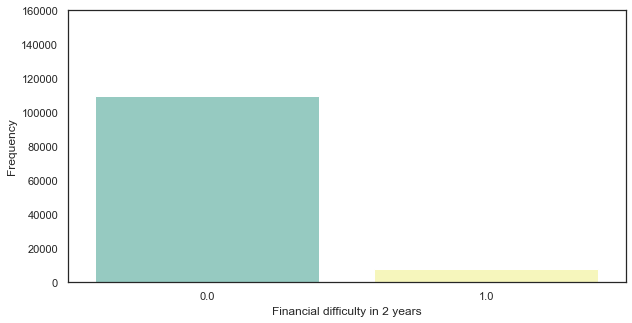

In [8]:
ax = sns.countplot(x = train.SeriousDlqin2yrs ,palette="Set3")
sns.set(font_scale=1.5)
ax.set_ylim(top = 150000)
ax.set_xlabel('Financial difficulty in 2 years')
ax.set_ylabel('Frequency')
fig = plt.gcf()
fig.set_size_inches(10,5)
ax.set_ylim(top=160000)

plt.show()

In [9]:
def detect_outliers(df,n,features):
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers

# detect outliers from Age, SibSp , Parch and Fare
# These are the numerical features present in the dataset
Outliers_to_drop = detect_outliers(train,2,["RevolvingUtilizationOfUnsecuredLines",
                                            "age",
                                            "NumberOfTime30-59DaysPastDueNotWorse",
                                            "DebtRatio",
                                            "MonthlyIncome",
                                            "NumberOfOpenCreditLinesAndLoans",
                                            "NumberOfTimes90DaysLate",
                                            "NumberRealEstateLoansOrLines",
                                            "NumberOfTime60-89DaysPastDueNotWorse",
                                            "Unnamed: 0",
                                            "NumberOfDependents"])

In [10]:
train.loc[Outliers_to_drop]

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents


In [11]:
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [12]:
train_len = len(train)
dataset =  pd.concat(objs=[train, kaggle_test], axis=0).reset_index(drop=True)

In [13]:
dataset.shape

(250840, 12)

In [14]:
dataset = dataset.rename(columns={'Unnamed: 0': 'Unknown',
                                  'SeriousDlqin2yrs': 'Target',
                                  'RevolvingUtilizationOfUnsecuredLines': 'UnsecLines',
                                  'NumberOfTime30-59DaysPastDueNotWorse': 'Late3059',
                                  'DebtRatio': 'DebtRatio',
                                  'MonthlyIncome': 'MonthlyIncome',
                                  'NumberOfOpenCreditLinesAndLoans': 'OpenCredit',
                                  'NumberOfTimes90DaysLate': 'Late90',
                                  'NumberRealEstateLoansOrLines': 'PropLines',
                                  'NumberOfTime60-89DaysPastDueNotWorse': 'Late6089',
                                  'NumberOfDependents': 'Deps'})

train = train.rename(columns={'Unnamed: 0': 'Unknown',
                                  'SeriousDlqin2yrs': 'Target',
                                  'RevolvingUtilizationOfUnsecuredLines': 'UnsecLines',
                                  'NumberOfTime30-59DaysPastDueNotWorse': 'Late3059',
                                  'DebtRatio': 'DebtRatio',
                                  'MonthlyIncome': 'MonthlyIncome',
                                  'NumberOfOpenCreditLinesAndLoans': 'OpenCredit',
                                  'NumberOfTimes90DaysLate': 'Late90',
                                  'NumberRealEstateLoansOrLines': 'PropLines',
                                  'NumberOfTime60-89DaysPastDueNotWorse': 'Late6089',
                                  'NumberOfDependents': 'Deps'})

kaggle_test = kaggle_test.rename(columns={'Unnamed: 0': 'Unknown',
                                  'SeriousDlqin2yrs': 'Target',
                                  'RevolvingUtilizationOfUnsecuredLines': 'UnsecLines',
                                  'NumberOfTime30-59DaysPastDueNotWorse': 'Late3059',
                                  'DebtRatio': 'DebtRatio',
                                  'MonthlyIncome': 'MonthlyIncome',
                                  'NumberOfOpenCreditLinesAndLoans': 'OpenCredit',
                                  'NumberOfTimes90DaysLate': 'Late90',
                                  'NumberRealEstateLoansOrLines': 'PropLines',
                                  'NumberOfTime60-89DaysPastDueNotWorse': 'Late6089',
                                  'NumberOfDependents': 'Deps'})

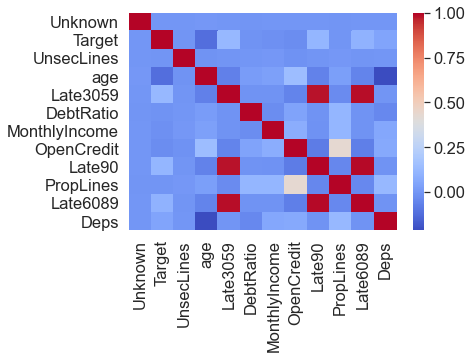

In [15]:
# Correlation matrix
g = sns.heatmap(train.corr(),annot=False, fmt = ".2f", cmap = "coolwarm")

In [16]:
dataset.UnsecLines.describe()

count    120655.000000
mean          5.957991
std         242.870223
min           0.000000
25%           0.029786
50%           0.153328
75%           0.557388
max       50708.000000
Name: UnsecLines, dtype: float64

In [17]:
dataset.UnsecLines = pd.qcut(dataset.UnsecLines.values, 5).codes

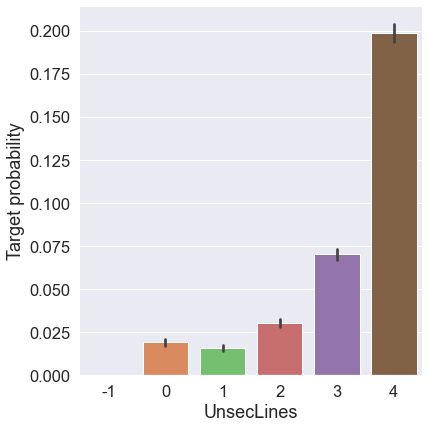

In [18]:
# Explore UnsecLines feature vs Target
g  = sns.factorplot(x="UnsecLines",y="Target",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

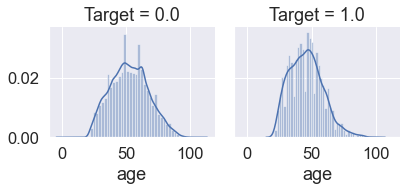

In [19]:
# Explore Age vs Survived
g = sns.FacetGrid(dataset, col='Target')
g = g.map(sns.distplot, "age")

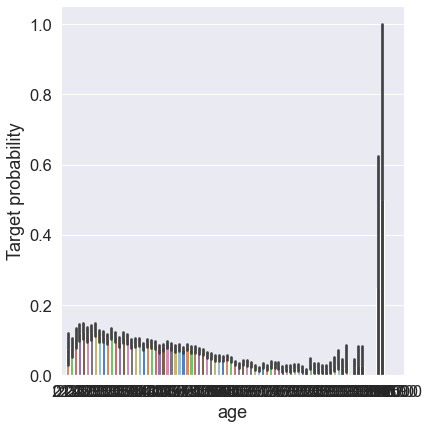

In [20]:
# Explore age feature vs Target
g  = sns.factorplot(x="age",y="Target",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

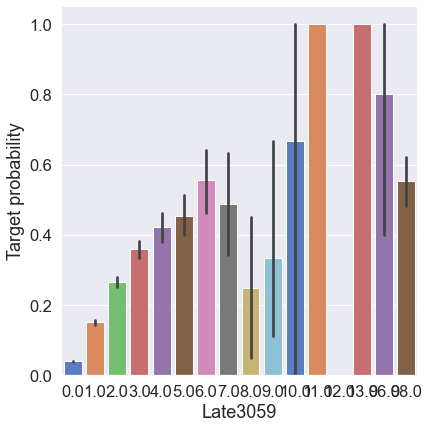

In [21]:
# Explore UnsecLines feature vs Target
g  = sns.factorplot(x="Late3059",y="Target",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

In [22]:
for i in range(len(dataset)):
    if dataset.Late3059[i] >= 6:
        dataset.Late3059[i] = 6

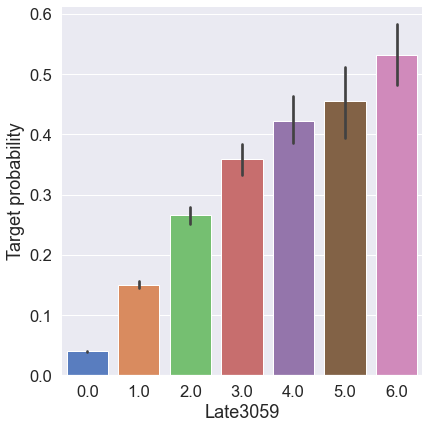

In [23]:
# Explore UnsecLines feature vs Target
g  = sns.factorplot(x="Late3059",y="Target",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

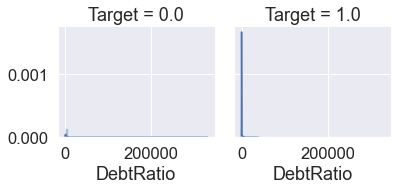

In [24]:
# Explore Age vs Survived
g = sns.FacetGrid(dataset, col='Target')
g = g.map(sns.distplot, "DebtRatio")

In [25]:
dataset.DebtRatio = pd.qcut(dataset.DebtRatio.values, 5).codes

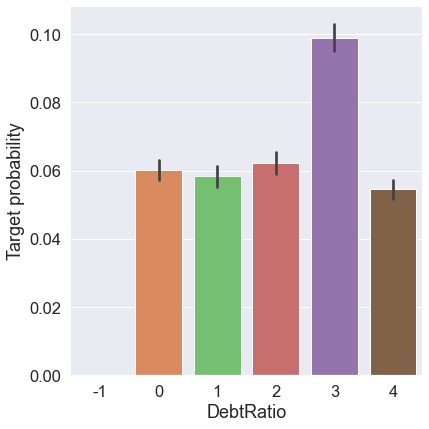

In [26]:
# Explore DebtRatio feature quantiles vs Target
g  = sns.factorplot(x="DebtRatio",y="Target",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

In [27]:
dataset.MonthlyIncome.isnull().sum()

153973

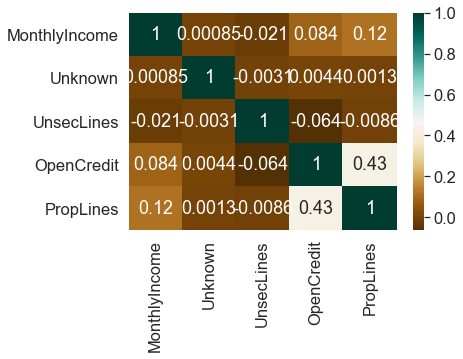

In [28]:
g = sns.heatmap(dataset[["MonthlyIncome","Unknown","UnsecLines","OpenCredit","PropLines"]].corr(),cmap="BrBG",annot=True)

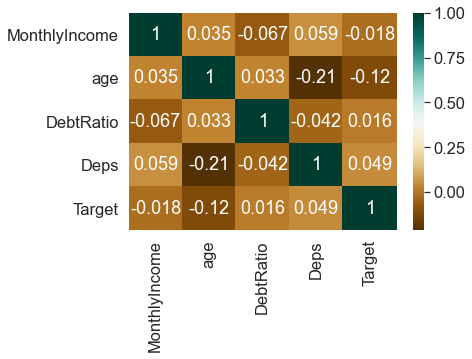

In [29]:
g = sns.heatmap(dataset[["MonthlyIncome","age","DebtRatio","Deps","Target"]].corr(),cmap="BrBG",annot=True)

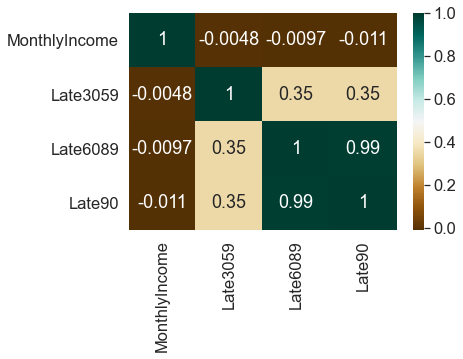

In [30]:
g = sns.heatmap(dataset[["MonthlyIncome","Late3059","Late6089","Late90"]].corr(),cmap="BrBG",annot=True)

In [31]:
dataset.MonthlyIncome.median()

5400.0

In [32]:
#Fill Embarked nan values of dataset set with 'S' most frequent value
dataset.MonthlyIncome = dataset.MonthlyIncome.fillna(dataset.MonthlyIncome.median())

In [37]:
dataset.MonthlyIncome = pd.qcut(dataset.MonthlyIncome.values, 5, duplicates='drop').codes

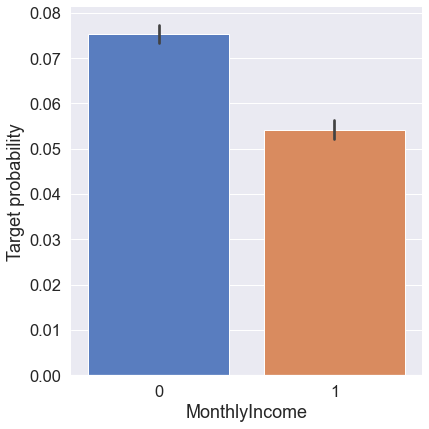

In [38]:
# Explore DebtRatio feature quantiles vs Target
g  = sns.factorplot(x="MonthlyIncome",y="Target",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

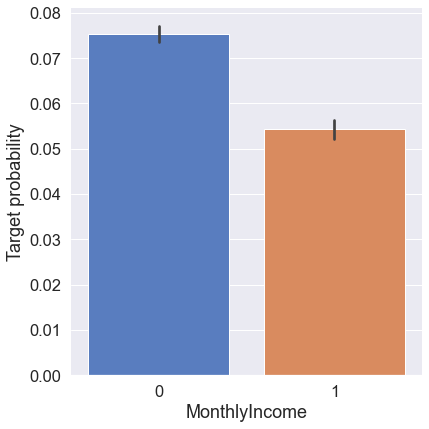

In [39]:
# Explore DebtRatio feature quantiles vs Target
g  = sns.factorplot(x="MonthlyIncome",y="Target",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

In [40]:
dataset.OpenCredit.describe()

count    120655.000000
mean          8.458812
std           5.153388
min           0.000000
25%           5.000000
50%           8.000000
75%          11.000000
max          57.000000
Name: OpenCredit, dtype: float64

In [41]:
dataset.OpenCredit = pd.qcut(dataset.OpenCredit.values, 5).codes

In [42]:
dataset.Late90.describe()

count    120655.000000
mean          0.264059
std           4.155853
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          98.000000
Name: Late90, dtype: float64

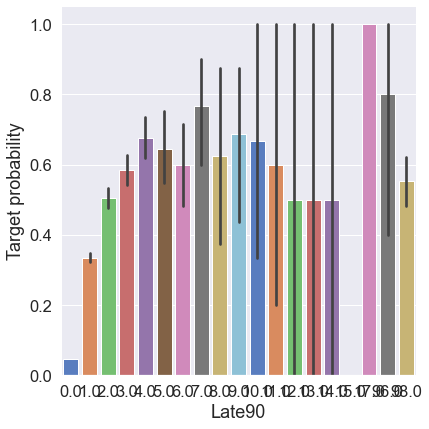

In [43]:
# Explore DebtRatio feature quantiles vs Target
g  = sns.factorplot(x="Late90",y="Target",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

In [44]:
for i in range(len(dataset)):
    if dataset.Late90[i] >= 5:
        dataset.Late90[i] = 5

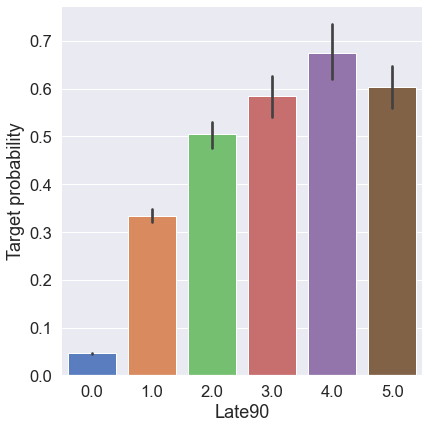

In [45]:
# Explore DebtRatio feature quantiles vs Target
g  = sns.factorplot(x="Late90",y="Target",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

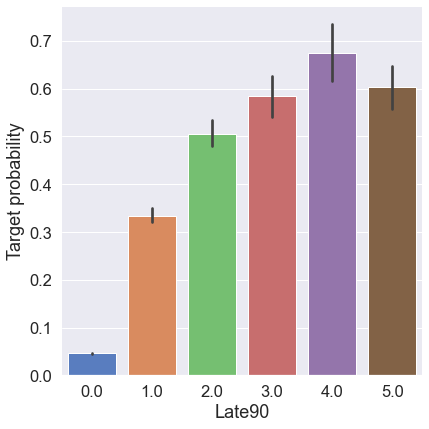

In [46]:
# Explore DebtRatio feature quantiles vs Target
g  = sns.factorplot(x="Late90",y="Target",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

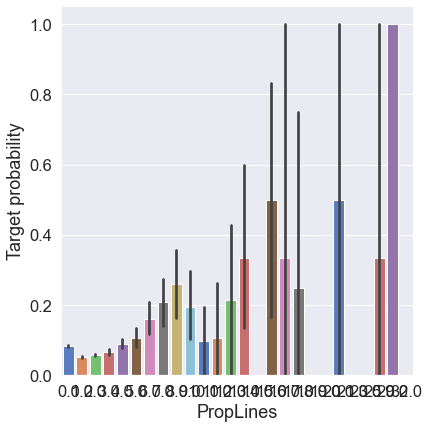

In [47]:
# Explore DebtRatio feature quantiles vs Target
g  = sns.factorplot(x="PropLines",y="Target",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

In [48]:
for i in range(len(dataset)):
    if dataset.PropLines[i] >= 6:
        dataset.PropLines[i] = 6

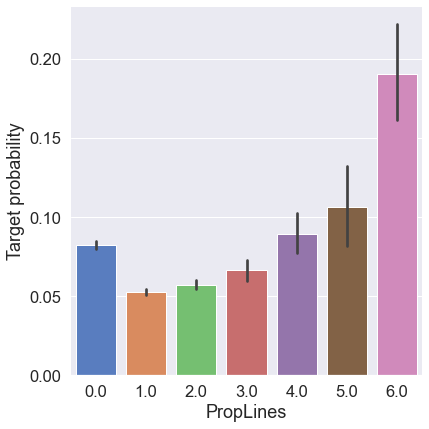

In [49]:
# Explore DebtRatio feature quantiles vs Target
g  = sns.factorplot(x="PropLines",y="Target",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

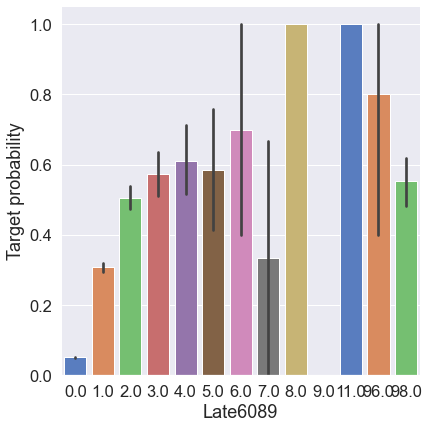

In [50]:
# Explore Late6089 feature quantiles vs Target
g  = sns.factorplot(x="Late6089",y="Target",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

In [51]:
for i in range(len(dataset)):
    if dataset.Late6089[i] >= 3:
        dataset.Late6089[i] = 3

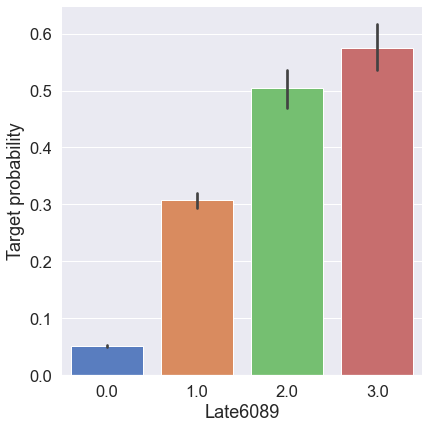

In [52]:
# Explore Late6089 feature quantiles vs Target
g  = sns.factorplot(x="Late6089",y="Target",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

In [53]:
dataset.Deps.describe()

count    117535.000000
mean          0.755741
std           1.113340
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          13.000000
Name: Deps, dtype: float64

In [54]:
dataset.Deps = dataset.Deps.fillna(dataset.Deps.median())

In [55]:
dataset.Deps.isnull().sum()

0

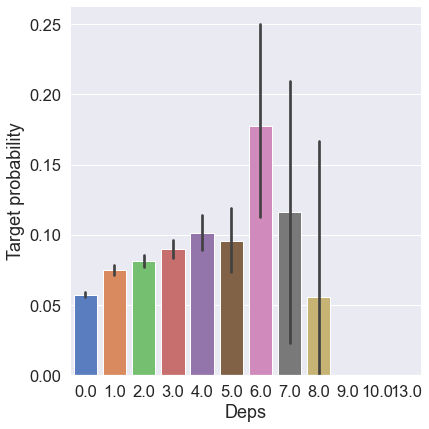

In [56]:
# Explore DebtRatio feature quantiles vs Target
g  = sns.factorplot(x="Deps",y="Target",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

In [57]:
for i in range(len(dataset)):
    if dataset.Deps[i] >= 4:
        dataset.Deps[i] = 4

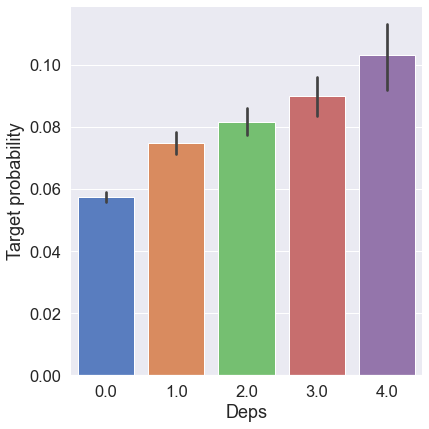

In [58]:
# Explore DebtRatio feature quantiles vs Target
g  = sns.factorplot(x="Deps",y="Target",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

In [59]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250840 entries, 0 to 250839
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unknown        120655 non-null  float64
 1   Target         117655 non-null  float64
 2   UnsecLines     250840 non-null  int8   
 3   age            120655 non-null  float64
 4   Late3059       120655 non-null  float64
 5   DebtRatio      250840 non-null  int8   
 6   MonthlyIncome  250840 non-null  int8   
 7   OpenCredit     250840 non-null  int8   
 8   Late90         120655 non-null  float64
 9   PropLines      120655 non-null  float64
 10  Late6089       120655 non-null  float64
 11  Deps           250840 non-null  float64
dtypes: float64(8), int8(4)
memory usage: 16.3 MB


In [60]:
dataset.head()

,Unknown,Target,UnsecLines,age,Late3059,DebtRatio,MonthlyIncome,OpenCredit,Late90,PropLines,Late6089,Deps
0,1.0,1.0,4,45.0,2.0,3,1,4,0.0,6.0,0.0,2.0
1,2.0,0.0,4,40.0,0.0,0,0,0,0.0,0.0,0.0,1.0
2,3.0,0.0,3,38.0,1.0,0,0,0,1.0,0.0,0.0,0.0
3,4.0,0.0,2,30.0,0.0,0,0,1,0.0,0.0,0.0,0.0
4,5.0,0.0,4,49.0,1.0,0,1,2,0.0,1.0,0.0,0.0


In [61]:
dataset = pd.get_dummies(dataset, columns = ["UnsecLines"], prefix="UnsecLines")
dataset = pd.get_dummies(dataset, columns = ["age"], prefix="age")
dataset = pd.get_dummies(dataset, columns = ["Late3059"], prefix="Late3059")
dataset = pd.get_dummies(dataset, columns = ["DebtRatio"], prefix="DebtRatio")
dataset = pd.get_dummies(dataset, columns = ["MonthlyIncome"], prefix="MonthlyIncome")
dataset = pd.get_dummies(dataset, columns = ["OpenCredit"], prefix="OpenCredit")
dataset = pd.get_dummies(dataset, columns = ["Late90"], prefix="Late90")
dataset = pd.get_dummies(dataset, columns = ["PropLines"], prefix="PropLines")
dataset = pd.get_dummies(dataset, columns = ["Late6089"], prefix="Late6089")
dataset = pd.get_dummies(dataset, columns = ["Deps"], prefix="Deps")

In [62]:
dataset.head()

,Unknown,Target,UnsecLines_-1,UnsecLines_0,UnsecLines_1,UnsecLines_2,UnsecLines_3,UnsecLines_4,age_0.0,age_21.0,age_22.0,age_23.0,age_24.0,age_25.0,age_26.0,age_27.0,age_28.0,age_29.0,age_30.0,age_31.0,age_32.0,age_33.0,age_34.0,age_35.0,age_36.0,age_37.0,age_38.0,age_39.0,age_40.0,age_41.0,age_42.0,age_43.0,age_44.0,age_45.0,age_46.0,age_47.0,age_48.0,age_49.0,age_50.0,age_51.0,age_52.0,age_53.0,age_54.0,age_55.0,age_56.0,age_57.0,age_58.0,age_59.0,age_60.0,age_61.0,...,age_99.0,age_101.0,age_102.0,age_103.0,age_105.0,age_107.0,age_109.0,Late3059_0.0,Late3059_1.0,Late3059_2.0,Late3059_3.0,Late3059_4.0,Late3059_5.0,Late3059_6.0,DebtRatio_-1,DebtRatio_0,DebtRatio_1,DebtRatio_2,DebtRatio_3,DebtRatio_4,MonthlyIncome_0,MonthlyIncome_1,OpenCredit_-1,OpenCredit_0,OpenCredit_1,OpenCredit_2,OpenCredit_3,OpenCredit_4,Late90_0.0,Late90_1.0,Late90_2.0,Late90_3.0,Late90_4.0,Late90_5.0,PropLines_0.0,PropLines_1.0,PropLines_2.0,PropLines_3.0,PropLines_4.0,PropLines_5.0,PropLines_6.0,Late6089_0.0,Late6089_1.0,Late6089_2.0,Late6089_3.0,Deps_0.0,Deps_1.0,Deps_2.0,Deps_3.0,Deps_4.0
0,1.0,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0
1,2.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
2,3.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
3,4.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
4,5.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0


In [63]:
dataset.shape

(250840, 137)

In [64]:
train = dataset[:train_len]
Kaggle_test = dataset[train_len:]
Kaggle_test.drop(labels=["Target"],axis = 1,inplace=True)

In [65]:
Kaggle_test.shape

(100798, 136)

In [71]:
## Separate train features and label 

train["Target"] = train["Target"].astype(int)

Y_train = train["Target"]

X_train = train.drop(labels = ["Target", "Unknown"],axis = 1)

ValueError: Cannot convert non-finite values (NA or inf) to integer

In [72]:
clf = RandomForestClassifier(n_estimators=50, max_features='sqrt')
clf = clf.fit(X_train, Y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [70]:
features = pd.DataFrame()
features['feature'] = X_train.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
features.plot(kind='barh', figsize=(20, 20))

In [ ]:
parameters = {'n_estimators': 1000, 'random_state' : 20}
    
model = RandomForestClassifier(**parameters)
model.fit(X_train, Y_train)

In [ ]:
Kaggle_test.head()

In [ ]:
results_df = pd.read_csv("cs-tests.csv", error_bad_lines = False)

In [ ]:
results_df = results_df.drop(["RevolvingUtilizationOfUnsecuredLines",
                             "age",
                             "NumberOfTime30-59DaysPastDueNotWorse",
                             "DebtRatio",
                             "MonthlyIncome",
                             "NumberOfOpenCreditLinesAndLoans",
                             "NumberOfTimes90DaysLate",
                             "NumberRealEstateLoansOrLines",
                             "NumberOfTime60-89DaysPastDueNotWorse",
                             "NumberOfDependents"], axis=1)

In [ ]:
DefaultProba = model.predict_proba(Kaggle_test.drop(["Unknown"], axis=1))
DefaultProba = DefaultProba[:,1]
results_df.SeriousDlqin2yrs = DefaultProba

results_df = results_df.rename(columns={'Unnamed: 0': 'Id',
                                        'SeriousDlqin2yrs': 'Probability'})

In [ ]:
results_df.head()

In [ ]:
results_df.to_csv('C:\\Users\\Enzo\\Desktop\\UPM\\3rd-Year-1st-Sem\\CMSC 176\\CMSC176-MP\\CMSC-176-Credit_Risk\\KAGGLE_CREDIT_SCORE.csv')